## Importing dependencies

In [1]:
import numpy as np
import pandas as pd

import unicodedata, re, string
import nltk

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
import os
print(os.listdir("../input"))

['test.tsv', 'sampleSubmission.csv', 'train.tsv']


## Exploring The  Data

In [2]:
df_train = pd.read_csv("../input/train.tsv", sep="\t")
df_test = pd.read_csv("../input/test.tsv", sep="\t")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [4]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
df_train['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [6]:
df_train.loc[df_train['SentenceId'] == 1]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


As was mentioned in the original competition description, there are no individual movie reviews but rather phrases taken out of context and split into smaller parts, each with an assigned sentiment category. The competition is evaluated based on scoring results of each test phrase, so the context of the whole review does not matter here. The data is also fairly clean, so there will not be need for much pre-processing.
Before proceeding it is also a good idea to look at distribution of data, to see if the classes in training set are evenly distributed. For that I borrowed code from another Kaggle kernel:

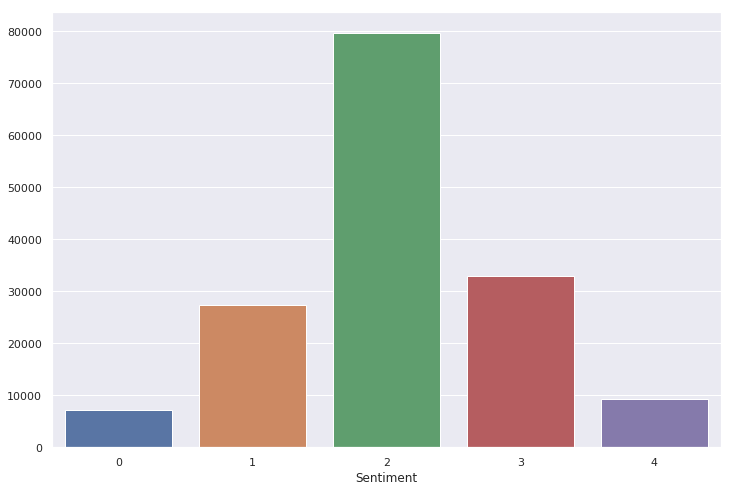

In [7]:
dist = df_train.groupby(["Sentiment"]).size()

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(dist.keys(), dist.values);

Classes seem to follow a normal distribution, with most frequently distributed class being "2".  This could lead to model not having sufficient data to learn the less-represented classes. This is something to be aware of when evaluating the model.

## Pre-Processing

Words need to be tokenized into numeric format to be passed to RNN. Before that, however, I will also filter out spaces and punctuation, and use lemmatization to further reduce dimensionality. At this moment I do not want to filter out "stop-words", as RNN's are good at learning context from previously encountered information. In case of movie reviews, phrase "this movie is shit" has opposite meaning of "this movie is the shit", so I want that information to be available to the model.

Below are some helper functions I borrowed online to help prepare the data:

In [8]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words

Time to get the hands dirty. First I will go through the dataframe and tokenize each word using NLTK. Then I will pass each token through the prepping functions I created earlier, with the end result being a reduced list of lemmatized word tokens:

In [9]:
# First step - tokenizing phrases
df_train['Words'] = df_train['Phrase'].apply(nltk.word_tokenize)

# Second step - passing through prep functions
df_train['Words'] = df_train['Words'].apply(normalize) 
df_train['Words'].head()

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Words, dtype: object

Looks ok. Now the next prep step - converting words to number representations, as the embedding lookup requires that integers are passed to the network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Using this vocab then words in each phrase can be converted to integers:

In [10]:
# Third step - creating a list of unique words to be used as dictionary for encoding
word_set = set()
for l in df_train['Words']:
    for e in l:
        word_set.add(e)
        
word_to_int = {word: ii for ii, word in enumerate(word_set, 1)}

# Check if they are still the same lenght
print(len(word_set))
print(len(word_to_int))


16209
16209


In [11]:
# Now the dict to tokenize each phrase
df_train['Tokens'] = df_train['Words'].apply(lambda l: [word_to_int[word] for word in l])
df_train['Tokens'].head()

0    [4734, 7706, 1467, 11411, 6263, 15150, 3271, 1...
1    [4734, 7706, 1467, 11411, 6263, 15150, 3271, 1...
2                                         [4734, 7706]
3                                               [4734]
4                                               [7706]
Name: Tokens, dtype: object

So far so good. But for the input to the network the length of each phrase sequence has to be equal, so the shorter phrases will need to be "padded" - zeros added so that their token numbers are the same length.

In [12]:
# Step four - get the len of longest phrase
max_len = df_train['Tokens'].str.len().max()
print(max_len)

48


In [13]:
# Pad each phrase representation with zeroes, starting from the beginning of sequence
# Will use a combined list of phrases as np array for further work. This is expected format for the Pytorch utils to be used later

all_tokens = np.array([t for t in df_train['Tokens']])
encoded_labels = np.array([l for l in df_train['Sentiment']])

# Create blank rows
features = np.zeros((len(all_tokens), max_len), dtype=int)
# for each phrase, add zeros at the end 
for i, row in enumerate(all_tokens):
    features[i, :len(row)] = row

#print first 3 values of the feature matrix 
print(features[:3])

 

[[ 4734  7706  1467 11411  6263 15150  3271 10684  7577 14821 14459 15578
  15150  4062 14821 11072 14459 15578 15150  1584  8704  1467  9235 13130
  10904 13862 11013  1467  9235 12041  8248 11118  1467  4734  7777     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 4734  7706  1467 11411  6263 15150  3271 10684  7577 14821 14459 15578
  15150  4062     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]
 [ 4734  7706     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]


## Splitting the Data for Training, Validation, Test

Time to split the data into training, validation, and test sets. For this purpose I will reserve 80% of training data for training, and remaining 20% will be split equally for validation and testing purposes.


In [14]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*0.8)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of  resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(124848, 48) 
Validation set: 	(15606, 48) 
Test set: 		(15606, 48)


## DataLoaders and Batching
After creating training, test, and validation data, time top create DataLoaders. They are the expected way to pass data into the model for training / testing. Loaders are created by following two steps:

1) Create a known format for accessing data, using TensorDataset which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.

2) Create DataLoaders and batch our training, validation, and test Tensor datasets.

In [15]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 54

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Check the size of the loaders (how many batches inside)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

2312
289
289


## Creating a Deep Network

The following text is borrowed from another excersize file, but it describes the approach of model building very well:

1) First, we'll pass in words to an embedding layer. We need an embedding layer because we have thousands of words, so we'll need a more efficient representation for our input data than one-hot encoded vectors. In this case, the embedding layer is for dimensionality reduction, rather than for learning semantic representations.

2) After input words are passed to an embedding layer, the new embeddings will be passed to LSTM cells. The LSTM cells will add recurrent connections to the network and give us the ability to include information about the sequence of words in the movie review data.
LSTM takes in an input_size, a hidden_dim, a number of layers, a dropout probability (for dropout between multiple layers), and a batch_first parameter.

3) Finally, the LSTM outputs will go to a linear layer for final classification, which outputs in turn will be passed to cross-entropy loss function to obtain probabilities for each predicted class.

The layers are as follows:
* An embedding layer that converts word tokens (integers) into embeddings of a specific size.
* An LSTM layer defined by a hidden_state size and number of layers
* A fully-connected output layer that maps the LSTM layer outputs to a desired output_size
* A softmax will be applyed later by Crossentropy loss function, which turns all outputs into a probability

Most of the time, the network will have better performance with more layers; between 2-3. Adding more layers allows the network to learn really complex relationships.


In [16]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [17]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment Detection.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(embeds, hidden)

        # transform lstm output to input size of linear layers
        lstm_out = lstm_out.transpose(0,1)
        lstm_out = lstm_out[-1]

        out = self.dropout(lstm_out)
        out = self.fc(out)        

        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

## Instantiate the network
Here, we'll instantiate the network. First up, defining the hyperparameters.
* vocab_size: Size of our vocabulary or the range of values for our input, word tokens.
* output_size: Size of our desired output; the number of class scores we want to output (0..4).
* embedding_dim: Number of columns in the embedding lookup table; size of our embeddings.
* hidden_dim: Number of units in the hidden layers of our LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* n_layers: Number of LSTM layers in the network. Typically between 1-3

In [18]:
# Instantiate the model w/ hyperparams
vocab_size = len(word_to_int)+1 # +1 for the 0 padding
output_size = 5
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(16210, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


## Training Routine
Below is the typical training code. 
Crossentropy loss will be used, since this is multi-class classification problem.
We also have some data and training hyparameters:
* lr: Learning rate for our optimizer.
* epochs: Number of times to iterate through the training dataset.
* clip: The maximum gradient value to clip at (to prevent exploding gradients).

In [19]:
# loss and optimization functions
lr=0.003

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [20]:
# training params
epochs = 3 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        # calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output, labels)

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/3... Step: 100... Loss: 1.230594... Val Loss: 1.313183
Epoch: 1/3... Step: 200... Loss: 1.301816... Val Loss: 1.302561
Epoch: 1/3... Step: 300... Loss: 1.377407... Val Loss: 1.302779
Epoch: 1/3... Step: 400... Loss: 1.130379... Val Loss: 1.301292
Epoch: 1/3... Step: 500... Loss: 1.047430... Val Loss: 1.285534
Epoch: 1/3... Step: 600... Loss: 1.207994... Val Loss: 1.255173
Epoch: 1/3... Step: 700... Loss: 1.187926... Val Loss: 1.247271
Epoch: 1/3... Step: 800... Loss: 1.011234... Val Loss: 1.222823
Epoch: 1/3... Step: 900... Loss: 1.128768... Val Loss: 1.216487
Epoch: 1/3... Step: 1000... Loss: 1.293388... Val Loss: 1.202958
Epoch: 1/3... Step: 1100... Loss: 1.134912... Val Loss: 1.203455
Epoch: 1/3... Step: 1200... Loss: 1.018864... Val Loss: 1.188047
Epoch: 1/3... Step: 1300... Loss: 1.043085... Val Loss: 1.177926
Epoch: 1/3... Step: 1400... Loss: 1.097577... Val Loss: 1.168784
Epoch: 1/3... Step: 1500... Loss: 1.299792... Val Loss: 1.158775
Epoch: 1/3... Step: 1600... Loss: 

## Testing

There are a few ways to test your network.
* Test data performance: First, we'll see how our trained model performs on all of our defined test_data, above. We'll calculate the average loss and accuracy over the test data.
* Inference on user-generated data: Second, we'll see if we can input just one example review at a time (without a label), and see what the trained model predicts. Looking at new, user input data like this, and predicting an output label, is called inference.

For the practical purposes of this example, though, second option is not applicable, as the task is to classify syntetic colection of provided phrases.

In [21]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output,1)
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 1.083
Test accuracy: 0.573
